In [20]:
import os
import pickle
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt

# TASK = "Ant-v2"
# TASK = "HalfCheetah-v2"
# TASK = "Hopper-v2"
# TASK = "Humanoid-v2"
# TASK = "Reacher-v2"
# TASK = "Walker2d-v2"

TASK_LIST = ["Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Humanoid-v2", "Reacher-v2", "Walker2d-v2"]

DIRNAME_experts = "experts"
DIRNAME_expert_data = "expert_data"
DIRNAME_MODELS = "BC_models"
DIRNAME_output = "output"

BATCH_SIZE = 64
EPOCHS = 100

## Problem 2.2
    First, we build, train and save the models for the tasks in TASK_LIST.
    Next, we load and test each model.
    Last, we collect the results of each model (mean and std of rewards over 20 iterations).
    
    The models were built and trained already and are located in the directory BC_models. Skip building an training them or delete this directory to build and train the models again.

In [21]:
def build_train_save_model(X_train, Y_train, model_path, batch_size=BATCH_SIZE, epochs=EPOCHS):
    
    print("The shapes of training input and output: X:{}, Y:{}".format(X_train.shape, Y_train.shape))
    sample_size = X_train.shape[0]
    input_size = X_train.shape[-1]
    output_size = Y_train.shape[-1]
    
    model = tf.keras.Sequential()
    
    # Hidden layer 1: input -> output (64,)
    model.add( tf.keras.layers.Dense(64, input_dim=input_size) )
    model.add( tf.keras.layers.Activation("relu") )
    
    # Hidden layer 2: output (64,) -> output (64,)
    model.add( tf.keras.layers.Dense(64) )
    model.add( tf.keras.layers.Activation("relu") )
    
    # Hidden layer 3: output (64,) -> output
    model.add( tf.keras.layers.Dense(output_size) )
    
    model.compile(loss="mse", optimizer="Adam")
    print("Training model ...")
    model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=1)
    
    model_dir = os.path.dirname(model_path)
    if not os.path.isdir( model_dir ):
        os.makedirs(model_dir)
        
    model.save(model_path)

    
for task in TASK_LIST:
    model_name = "BC_model_" + task + ".h5"
    model_path = os.path.join(DIRNAME_MODELS, model_name)
    
    if not os.path.exists(model_path):
        print("Task {}. Behavioral Cloning.".format(task))
        datafile = os.path.join(DIRNAME_expert_data, task + ".pkl")
        
        with open(datafile, 'rb') as f:
            expert_data = pickle.load(f)

        X_train = expert_data["observations"]
        Y_train = np.squeeze( expert_data["actions"] )
        
        build_train_save_model(X_train, Y_train, model_path)
        print()
        
    else:
        print("Model of " + task + " exists in the directory " + DIRNAME_MODELS + '.')
        print()

Model of Ant-v2 exists in the directory BC_models.

Model of HalfCheetah-v2 exists in the directory BC_models.

Model of Hopper-v2 exists in the directory BC_models.

Model of Humanoid-v2 exists in the directory BC_models.

Model of Reacher-v2 exists in the directory BC_models.

Model of Walker2d-v2 exists in the directory BC_models.



In [22]:
def load_test_model(task, model_path):

    model = tf.keras.models.load_model(model_path)
    
    envname = task
    env = gym.make(envname)
    max_steps = env.spec.timestep_limit
    num_rollouts = 20
    
    rewards = []
    observations = []
    actions = []
    for i in range(num_rollouts):
        print("iter", i)
        obs = env.reset()
        done = False
        total_reward = 0
        steps = 0
        while not done:
            action = model.predict(obs.reshape(1, -1), verbose=0)
            observations.append(obs)
            actions.append(action)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1
            if False:
                env.render()
#             if steps % 100 == 0:
#                 print("{}/{}".format(steps, max_steps))
            if steps >= max_steps:
                break
        rewards.append(total_reward)
        
    mean_reward, std_reward = np.mean(rewards), np.std(rewards)
    print("rewards", rewards)
    print("mean reward", mean_reward)
    print("std of reward", std_reward)
    
    ret_dict = {"rewards": rewards, "mean reward": mean_reward, "std of reward": std_reward}
    
    return ret_dict


for task in TASK_LIST:
    model_name = "BC_model_" + task + ".h5"
    model_path = os.path.join(DIRNAME_MODELS, model_name)
    
    if os.path.exists(model_path):
        print("Task {}. Behavioral Cloning".format(task))
        load_test_model(task, model_path)
        print()
        
    else:
        print("Model of " + task + " doest not exist. Build and train it first.")
        print()

Task Ant-v2. Behavioral Cloning
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
rewards [4795.814486983164, 4863.421658116031, 4779.958026567731, 4647.43879367636, 4819.813104734592, 4841.787095732694, 4852.739062724923, 4976.429785899354, 4799.927384369573, 4907.93983233427, 4914.238221893906, 4780.210411179718, 4866.566576606987, 4573.113958238297, 4564.407389902488, 4717.181374821776, 4676.222907900323, 4758.021051189747, 4906.945279666806, 5032.016071399261]
mean reward 4803.709623696899
std of reward 120.2507277428963

Task HalfCheetah-v2. Behavioral Cloning
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetect

## Problem 2.3
    Task selected: Ant.
    Examine the performance over a wide range of training epochs.

In [41]:
TASK_multi_epoch = "Ant-v2"
epoch_range = range(2, 41, 2)

for epoch_num in epoch_range:
    model_name = "BC_model_" + TASK_multi_epoch + "_epochs_" + str(epoch_num) + ".h5"
    model_dir = TASK_multi_epoch + "_epochs"
    model_path = os.path.join(DIRNAME_MODELS, model_dir, model_name)
    
    if not os.path.exists(model_path):
        print("Task {}. Building and Training model over {} epochs:".format(TASK_multi_epoch, epoch_num))
        datafile = os.path.join(DIRNAME_expert_data, TASK_multi_epoch + ".pkl")
        
        with open(datafile, 'rb') as f:
            expert_data = pickle.load(f)

        X_train = expert_data["observations"]
        Y_train = np.squeeze( expert_data["actions"] )
        build_train_save_model(X_train, Y_train, model_path, epochs=epoch_num)
        print()
        
    else:
        print("Model of " + TASK_multi_epoch + ", trained over " + str(epoch_num)
              + " epoches, exists in the directory " + os.path.join(DIRNAME_MODELS, model_dir) + '.')
        print()

Task Ant-v2. Building and Training model over 2 epochs:
The shapes of training input and output: X:(20000, 111), Y:(20000, 8)
Training model ...
Epoch 1/2
20000/20000 [==============================] - 1s 45us/step - loss: 0.0353
Epoch 2/2
20000/20000 [==============================] - 0s 13us/step - loss: 0.0115

Task Ant-v2. Building and Training model over 4 epochs:
The shapes of training input and output: X:(20000, 111), Y:(20000, 8)
Training model ...
Epoch 1/4
20000/20000 [==============================] - 1s 44us/step - loss: 0.0445
Epoch 2/4
20000/20000 [==============================] - 0s 13us/step - loss: 0.0129
Epoch 3/4
20000/20000 [==============================] - 0s 13us/step - loss: 0.0093
Epoch 4/4
20000/20000 [==============================] - 0s 13us/step - loss: 0.0076

Task Ant-v2. Building and Training model over 6 epochs:
The shapes of training input and output: X:(20000, 111), Y:(20000, 8)
Training model ...
Epoch 1/6
20000/20000 [==============================

Epoch 9/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0037
Epoch 10/18
20000/20000 [==============================] - 0s 14us/step - loss: 0.0033
Epoch 11/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0030
Epoch 12/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0027
Epoch 13/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0025
Epoch 14/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0024
Epoch 15/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 16/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 17/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0019
Epoch 18/18
20000/20000 [==============================] - 0s 13us/step - loss: 0.0019

Task Ant-v2. Building and Training model over 20 epochs:
The shapes of training input and output: X:(20000, 111), Y:(20000, 8)
Tra

20000/20000 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 13/26
20000/20000 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 14/26
20000/20000 [==============================] - 0s 14us/step - loss: 0.0021
Epoch 15/26
20000/20000 [==============================] - 0s 13us/step - loss: 0.0019
Epoch 16/26
20000/20000 [==============================] - 0s 13us/step - loss: 0.0019
Epoch 17/26
20000/20000 [==============================] - 0s 13us/step - loss: 0.0018
Epoch 18/26
20000/20000 [==============================] - 0s 14us/step - loss: 0.0017
Epoch 19/26
20000/20000 [==============================] - 0s 14us/step - loss: 0.0016
Epoch 20/26
20000/20000 [==============================] - 0s 13us/step - loss: 0.0016
Epoch 21/26
20000/20000 [==============================] - 0s 13us/step - loss: 0.0015
Epoch 22/26
20000/20000 [==============================] - 0s 14us/step - loss: 0.0014
Epoch 23/26
20000/20000 [==============================

20000/20000 [==============================] - 0s 16us/step - loss: 0.0019
Epoch 18/32
20000/20000 [==============================] - 0s 16us/step - loss: 0.0017
Epoch 19/32
20000/20000 [==============================] - 0s 15us/step - loss: 0.0017
Epoch 20/32
20000/20000 [==============================] - 0s 16us/step - loss: 0.0016
Epoch 21/32
20000/20000 [==============================] - 0s 16us/step - loss: 0.0015
Epoch 22/32
20000/20000 [==============================] - 0s 15us/step - loss: 0.0015
Epoch 23/32
20000/20000 [==============================] - 0s 15us/step - loss: 0.0015
Epoch 24/32
20000/20000 [==============================] - 0s 14us/step - loss: 0.0014
Epoch 25/32
20000/20000 [==============================] - 0s 14us/step - loss: 0.0013
Epoch 26/32
20000/20000 [==============================] - 0s 15us/step - loss: 0.0013
Epoch 27/32
20000/20000 [==============================] - 0s 14us/step - loss: 0.0013
Epoch 28/32
20000/20000 [==============================

20000/20000 [==============================] - 0s 14us/step - loss: 0.0070
Epoch 5/38
20000/20000 [==============================] - 0s 15us/step - loss: 0.0060
Epoch 6/38
20000/20000 [==============================] - 0s 15us/step - loss: 0.0051
Epoch 7/38
20000/20000 [==============================] - 0s 15us/step - loss: 0.0045
Epoch 8/38
20000/20000 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 9/38
20000/20000 [==============================] - 0s 14us/step - loss: 0.0035
Epoch 10/38
20000/20000 [==============================] - 0s 16us/step - loss: 0.0031
Epoch 11/38
20000/20000 [==============================] - 0s 14us/step - loss: 0.0028
Epoch 12/38
20000/20000 [==============================] - 0s 15us/step - loss: 0.0026
Epoch 13/38
20000/20000 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 14/38
20000/20000 [==============================] - 0s 15us/step - loss: 0.0022
Epoch 15/38
20000/20000 [==============================] - 0

In [42]:
performance_means_over_epochs = []
performance_stds_over_epochs = []

for epoch_num in epoch_range:
    model_name = "BC_model_" + TASK_multi_epoch + "_epochs_" + str(epoch_num) + ".h5"
    model_dir = TASK_multi_epoch + "_epochs"
    model_path = os.path.join(DIRNAME_MODELS, model_dir, model_name)
    
    if os.path.exists(model_path):
        print("Task {}. Model trained over {} epochs:".format(TASK_multi_epoch, epoch_num))
        ret_dict = load_test_model(TASK_multi_epoch, model_path)
        performance_means_over_epochs.append( ret_dict["mean reward"] )
        performance_stds_over_epochs.append( ret_dict["std of reward"] )
        print()
        
    else:
        print("Model of " + TASK_multi_epoch + ", trained over " + str(epoch_num)
              + " epoches, doest not exist. Build and train it first.")
        print()

Task Ant-v2. Model trained over 2 epochs:
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
rewards [813.7256841536159, 923.4632458325817, 1079.7848961710558, 1122.3512968119876, 1005.8180301863201, 1091.199850741454, 1130.7556781295552, 1064.6387332827771, 1093.2898398246741, 983.6434291618173, 1073.5246836727897, 930.9186782595432, 971.1402154378584, 1087.526620453397, 1075.098440984211, 1170.3456074416733, 974.2041853024716, 924.6694943556361, 973.4304931017753, 1038.0718624825884]
mean reward 1026.3800482893892
std of reward 86.13801542553337

Task Ant-v2. Model trained over 4 epochs:
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: g

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
rewards [4811.1392015009405, 4842.785426472752, 4732.384017349824, 4899.231337242583, 4943.567872698886, 4910.753456463385, 4635.2080755943525, 4726.86481263996, 4710.309789909099, 4811.313275256068, 4840.381399999457, 4716.703100341105, 4833.561053051133, 4944.258177727164, 4710.168990640483, 4729.664801792437, 4879.008156384222, 4828.947256314086, 4778.085181730472, 4738.139356026361]
mean reward 4801.123736956739
std of reward 85.09212559749496

Task Ant-v2. Model trained over 24 epochs:
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.

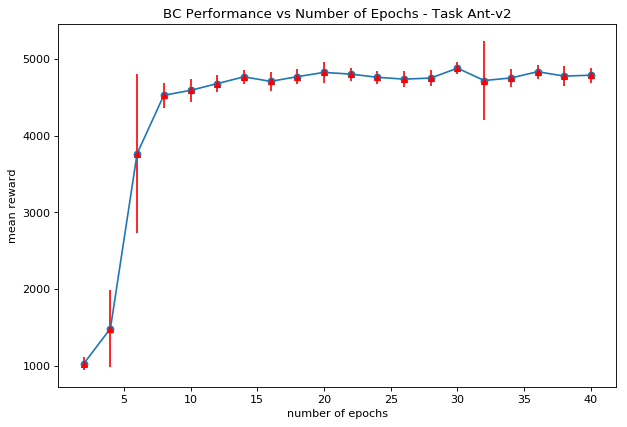

In [43]:
plt.figure(figsize=(9, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epoch_range, performance_means_over_epochs, "o-")
plt.errorbar(epoch_range, performance_means_over_epochs, performance_stds_over_epochs,
             color='r', linestyle="None", marker='^')
plt.title("BC Performance vs Number of Epochs - Task {}".format(TASK_multi_epoch))
plt.xlabel("number of epochs")
plt.ylabel("mean reward")
plt.savefig( os.path.join(DIRNAME_output, "BC_Performance_vs_Epochs_" + TASK_multi_epoch + ".png") )
plt.show()